# Linear Regression with Gradient Descent

##### Keywords: Theano, linear regression, gradient descent
##### Data:  http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv

## Equations for linear regression

Let's see briefly how gradient descent can be useful to us in least squares regression. Let's asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. We approximate $y$ by

$$f_\theta (x) =\theta^T x$$

The cost function for our linear least squares regression will then be

$$J(\theta) = \frac{1}{2} \sum_{i=1}^m (f_\theta (x^{(i)}-y^{(i)})^2$$

In this linear example it's easy to see that our update step then takes the form:

$$\theta_j := \theta_j + \alpha \sum_{i=1}^m (y^{(i)}-f_\theta (x^{(i)})) x_j^{(i)}$$
for every $j$ (note $\theta_j$ is simply the j-th component of the $\theta$ vector).
Similarly, the update equation in step 4 of the stochastic gradient descent method is

$$\theta_j := \theta_j + \alpha (y^{(i)}-f_\theta (x^{(i)})) x_j^{(i)}$$

We will use some advertisement data that consists of the amount of money spent to advertise different products in different media (features) as well as the the actual sales of the products (output). We are trying to determine if there is a correlation between the money spent and the sales for the different media (source: https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb). We will use Theano to perform linear regression with SGD, and to find the best coefficients that predict the sales as a function of the features.

## Using Theano

In [516]:
# Load dataset and show the first few entries:
import pandas as pd

# read data into a DataFrame
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [517]:
import numpy as np
ad_cost = np.asarray([data['TV'].values,data['Radio'].values,data['Newspaper'].values]).T
sales = np.asarray(data['Sales'].values)

Populating the interactive namespace from numpy and matplotlib


/Users/jmartine/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dot', 'gradient', 'generic', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


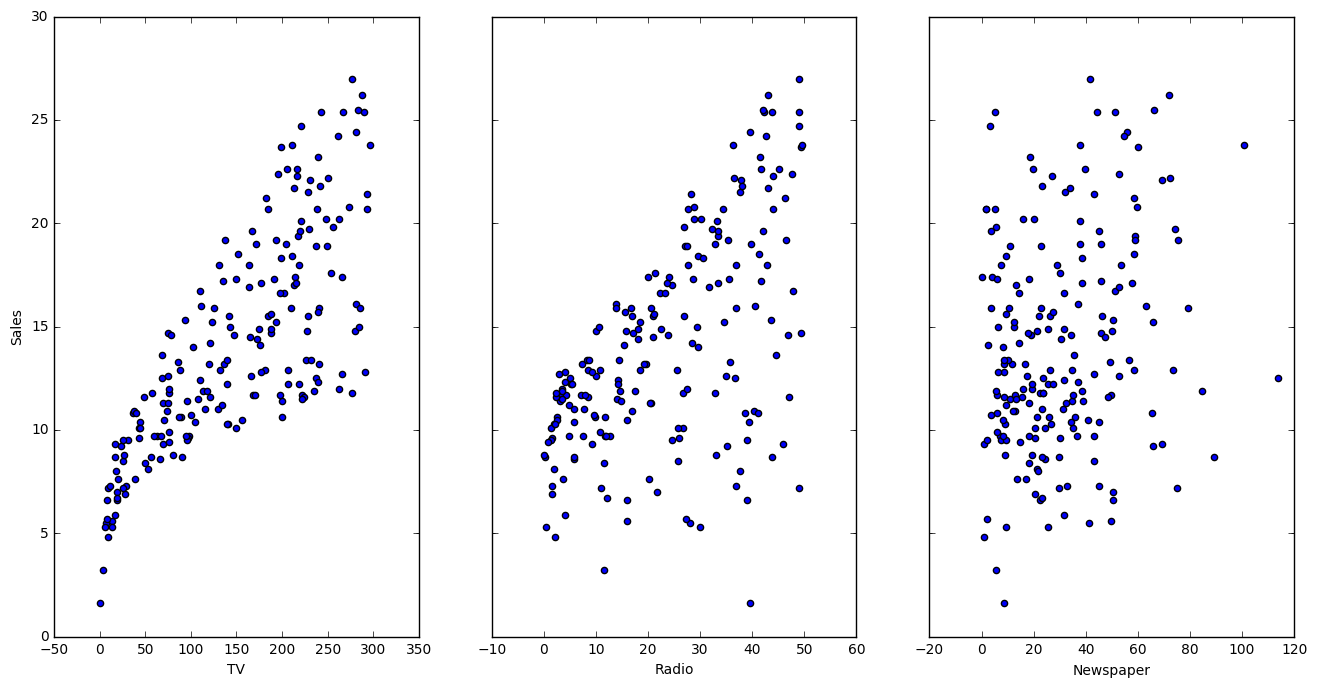

In [518]:
# Visualize the data 
% pylab inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])

In [519]:
n_examples = len(data['TV'])
n_examples

200

Now let us implement the linear regression in Theano:

In [520]:
from theano import *
import theano.tensor as T
from theano import function

In [521]:
# Declare vectors for features and output:
# Declare Theano symbolic variables
X = T.dmatrix("X")   # Featuers
S = T.dvector("S")   # Vector of outputs (sales)

In [522]:
# initialize the weight vector w randomly
# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
# We use a normal initialization
n_feats = 3 # Number of features
rng = numpy.random
#w = theano.shared(rng.randn(n_feats), name="w")
w = theano.shared(np.asarray(np.random.uniform(low = -np.sqrt(6. / (n_feats+200)), 
                                               high = np.sqrt(6. / (n_feats+200)),
                                               size = n_feats),dtype=theano.config.floatX))

# initialize the bias (intercept) term
b = theano.shared(np.asarray(0, dtype=theano.config.floatX))

In [523]:
# Let us print the initial model
print("Initial model:")
print(w.get_value())
print(b.get_value())

Initial model:
[-0.07802505  0.07229137 -0.16788819]
0.0


In [524]:
# Let us construct the Theano graph for computing the cost function
prediction = T.dot(X, w) + b  # The prediction for S, given the features X
# We have included L2 regulzarization (see below)
cost = T.sum(T.pow(prediction-S,2))/(2*n_examples)+ 0.01 * (w ** 2).sum()
#cost = T.sum(T.sqr(prediction - S)/float(n_examples))
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)                   # Compute the gradient of the cost
                                                # w.r.t weight vector w and
                                                # bias term b
                                                # (we shall return to this in a
                                                # following section of this tutorial)

In [525]:
# And now compile the training function
eta = 5E-5
train = theano.function(
          inputs=[X,S],
          outputs=[prediction, cost],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')

In [526]:
training_steps = 1000000
# Train
loss_trace = []
for i in range(training_steps):
    pred, err = train(ad_cost, sales)
    loss_trace.append(err)
    #print(w.get_value())

In [527]:
print("Final model:")
print(w.get_value())
print(b.get_value())

Final model:
[ 0.04577006  0.1885331  -0.00102064]
2.9372170550890693
